# First Look at Imaging - Modular

## About this Guide

**CARTA**

The purpose of this tutorial is to provide a first look at imaging ALMA
data for those new to CASA.

Data delivered by ALMA is pre-calibrated either by ARC staff or by the
ALMA calibration pipeline. The delivered data is ready for imaging. This
tutorial demonstrates the basic procedures that will help you complete
the imaging steps.

This guide covers the same material used in hands-on training sessions
at [NRAO Community Days
events](https://science.nrao.edu/facilities/alma/naasc-workshops/facilities/alma/community)
and ALMA Data Reduction tutorials presented by NAASC staff.



## Installation

First the system must be configured with the appropriate pre-requisite libraries to create a virtual display necessary for later plots/images.

In [1]:
# prerequisite system setup
import os
os.system('apt-get install xvfb')
os.system('pip install pyvirtualdisplay')

from pyvirtualdisplay import Display
display = Display(visible=0,size=(1024,768))
display.start( )

print('completed system setup')

completed system setup


Then we can choose from the available CASA packages to install: ```casatools, casatasks, casaplotms, casaviewer, almatasks, casampi, casashell, casadata, casampi, casaplotserver```

The pip installer generally handles dependencies automatically (for example casatasks needs casatools), however casadata is the exception that must be explicitly installed and updated by the user.

In [2]:
import os
print("installing casa packages...\n")
os.system('pip install casaconfig==1.4.0')
os.system('pip install casatools==6.7.2.42')
os.system('pip install casatasks==6.7.2.42')
print('completed')

installing casa packages...

completed


In [3]:
print("configuring casa...")
## For google colab
mydatapath = '/content/.casa/data'
## For a local install (choose any writeable path for upto 1GB of metadata)
#mydatapath = '<PATHNAME>/data'

import pathlib
from casaconfig import config
if not pathlib.Path(mydatapath).exists():
  pathlib.Path(mydatapath).mkdir(parents=True)
config.measurespath=mydatapath
print("complete")

configuring casa...
complete


## About the Sample Data: Continuum and N2H+ in TW Hydra

The data for this example comes from ALMA Project 2011.0.00340.S,
"Searching for H2D+ in the disk of TW Hya v1.5", for which the PI is
Chunhua Qi. Part of the data for this project has been published in [Qi et al. 2013](http://adsabs.harvard.edu/abs/2013Sci...341..630Q).

The original observation had three scientific objectives:

1.  Image the submm continuum structure in TW Hydra
2.  Image the H2D+ line structure (rest frequency 372.42138 GHz)
3.  Image the N2H+ line structure (rest frequency 372.67249 GHz)

The data used in our tutorial has already been calibrated. Furthermore,
to make the data set more manageable, we have reduced it in size by
averaging in time and frequency. Our goal will be to image the continuum
emission and the N2H+ spectral line, which is bright and well suited for
demonstrating the imaging techniques.

The spectral window we will image covers 234.375 MHz in bandwidth, and
contains 384 channels spaced by 610 kHz. The data includes observations
from 19 of the ALMA 12-m main array antennas, observed during Early
Science Cycle 0.

## Getting the Data

The data used in this tutorial is part of a larger data package used for
NRAO calibration and imaging tutorials. If you plan on working through
all of the "First Look" tutorials for CASA beginners, it is worth
downloading the entire package now. If you plan on working through just
this imaging tutorial then you can download a smaller data package (see
below).

The complete package (1.8G tarred and zipped, 2.6G unpacked) is
available [here](https://bulk.cv.nrao.edu/almadata/public/casaguides/FirstLook_TWHya_Band7_6.6.1/).

For the imaging tutorial, we are interested in the data that have been
flagged and calibrated. The relevant data set is called
"twhya_calibrated.ms". We here do not want to download the full 1.8G data package, so we download just the smaller data file (416M tarred, 1G unpacked) needed specifically for this tutorial.

You can download and unpack the data as follows:

In [4]:
print("downloading MeasurementSet from CASAguide First Look at Imaging...\n")
os.system("wget https://bulk.cv.nrao.edu/almadata/public/casaguides/FirstLook_TWHya_Band7_6.6.1/twhya_calibrated.ms.tar")
os.system("tar -xvf twhya_calibrated.ms.tar")
print("complete")

downloading MeasurementSet from CASAguide First Look at Imaging...

complete


Or you can download the file via your browser at the [following link](https://bulk.cv.nrao.edu/almadata/public/casaguides/FirstLook_TWHya_Band7_6.6.1/twhya_calibrated.ms.tar).


## Getting started with CASA

We can inspect the contents of a package, or better yet, read its corresponding API section in [CASAdocs](https://casadocs.readthedocs.io/en/stable/api.html)


In [5]:
import casatasks
casatasks.__all__

downloading casarundata contents to  /content/.casa/data (333M) ... done


['casalog',
 'version',
 'version_string',
 'imhead',
 'immoments',
 'imhistory',
 'appendantab',
 'applycal',
 'bandpass',
 'blcal',
 'calstat',
 'defintent',
 'concat',
 'split',
 'listobs',
 'flagdata',
 'flagcmd',
 'getephemtable',
 'setjy',
 'cvel',
 'cvel2',
 'importuvfits',
 'importfits',
 'exportfits',
 'exportuvfits',
 'partition',
 'listpartition',
 'flagmanager',
 'mstransform',
 'msuvbin',
 'tclean',
 'deconvolve',
 'immath',
 'vishead',
 'uvsub',
 'spxfit',
 'splattotable',
 'specsmooth',
 'specflux',
 'smoothcal',
 'specfit',
 'imstat',
 'slsearch',
 'delmod',
 'imsubimage',
 'accor',
 'asdmsummary',
 'clearcal',
 'conjugatevis',
 'exportasdm',
 'importasdm',
 'clearstat',
 'fixplanets',
 'fixvis',
 'phaseshift',
 'fluxscale',
 'ft',
 'gaincal',
 'gencal',
 'getantposalma',
 'testconcat',
 'apparentsens',
 'getcalmodvla',
 'hanningsmooth',
 'imcollapse',
 'imcontsub',
 'imdev',
 'imfit',
 'impbcor',
 'importasap',
 'importatca',
 'importfitsidi',
 'importgmrt',
 'importnr

We execute tasks just like normal Python functions. Many times they will write information to the log or a specified output file, which we then must display.

The first step in all data reduction with CASA is to examine the header
information and data structure for the data set using the **listobs**
task.

In [6]:
from casatasks import listobs

rc = listobs(vis='twhya_calibrated.ms', listfile='obslist.txt', verbose=False, overwrite=True)
!cat obslist.txt

           MeasurementSet Name:  /content/twhya_calibrated.ms      MS Version 2
   Observer: cqi     Project: uid://A002/X327408/X6f  
Observation: ALMA(26 antennas)
Data records: 68335       Total elapsed time = 5647.68 seconds
   Observed from   19-Nov-2012/07:36:57.0   to   19-Nov-2012/09:11:04.7 (UTC)

Fields: 5
  ID   Code Name                RA               Decl           Epoch   SrcId      nRows
  0    none J0522-364           05:22:57.984648 -36.27.30.85128 J2000   0           3420
  2    none Ceres               06:10:15.950590 +23.22.06.90668 J2000   2           3420
  3    none J1037-295           10:37:16.079736 -29.34.02.81316 J2000   3          13680
  5    none TW Hya              11:01:51.796000 -34.42.17.36600 J2000   4          44772
  6    none 3c279               12:56:11.166576 -05.47.21.52464 J2000   5           3043
Spectral Windows:  (1 unique spectral windows and 1 unique polarization setups)
  SpwID  Name                           #Chans   Frame   Ch0(MHz)  C

Now run plotms -- THERE IS A PROBLEM THAT I AM TRYING TO GET AROUND, SKIPPING PLOTMS FOR NOW (ADDED CODE TEXT JUST FOR PLACEHOLDER).

```
from casaplotms import plotms
print('making the plot...')

plotms(vis='twhya_calibrated.ms',plotfile='twhya_calibrated.jpg',showgui=False,highres=True,width=600,height=350,overwrite=True)

from IPython.display import Image
Image(filename="sis14_twhya_calibrated_flagged.jpg")

print('complete')
```

![Imaging-tutorial-uv-coverage_6.5.4](https://github.com/casangi/casadocs/blob/master/docs/notebooks/media/Imaging-tutorial-uv-coverage_6.5.4.jpg?raw=1){.image-inline width="600"}

In [7]:
# In CASA
os.system('rm -rf phase_cal.*')
print('complete')


complete


Now we will use the task **tclean** to do the imaging. Here is an
explanation of how we set some of the parameters; see the documentation
for a complete list of **tclean** options.

- We will first image the phase calibrator, and set the image name to
  "phase_cal". To identify the phase calibrator in a measurement set,
  look at the 'ScanIntent' column in the output of **listobs**. The
  phase calibrator should have the intent "CALIBRATE_PHASE#ON_SOURCE".
  In this MS, the phase calibrator is J1037-295, identified by field =
  "3".
- We will use multifrequency synthesis (specmode = mfs) to make a single
  continuum image. Multifrequency synthesis combines data from all
  selected spectral channels into a single continuum image. If your
  observations cover a large frequency range, it is possible that the
  amplitude or structure of the source can change substantially with
  frequency. This is only a concern if the fractional bandwidth
  (delta_nu/nu_center) is greater than 10%. For this dataset it is not
  an issue. Therefore, we set deconvolver=hogbom, which uses nterms=1,
  telling tclean that each deconvolved component has a single amplitude
  at all frequencies.
- We will image a single pointing, so we set gridder='standard'. If we
  had multiple, contiguous pointings-- or if we were simultaneously
  imaging 7m and 12m array data (even if only a single pointing of
  each)--- we would need to set gridder='mosaic'.
- We set the cell size to 0.1 arcseconds, which places ~5 pixels across
  the synthesized beam. As a rule of thumb, we'd like ~5 pixels across
  the smallest direction of our elliptical beam. For a small dataset,
  you may be able to determine a good cell size with a quick imaging
  call, and note the beam calculated by tclean. For many ALMA projects,
  however, this could take a substantial amount of time! You can
  estimate what the cell size should be by looking again at the
  uv-coverage. Change the x-axis to uvwave, and the cell size is roughly
  206265/(longest baseline in wavelengths)/(number of cells across the
  beam). For this MS, this works out to 0.09", which we round up to
  0.1". As you will see, tclean reports a synthesized beam size of 0.51"
  x 0.42", making this a decent choice.
- We choose the image size then based on the cell size. We want our
  image to cover the primary beam of a single antenna. For single fields
  with the 7m antennas, the primary beam in arcseconds is ~
  10608/nu_GHz, where nu_GHz is the central frequency expressed in GHz,
  and for single fields with the 12m antennas, the primary beam in
  arcseconds is ~ 6300/nu_GHz. The TW Hya data were taken with 12m
  antennas at a central frequency of 372.650 GHz, giving a primary beam
  of about 17". (For point sources, full coverage of the primary beam
  becomes less important, especially for well-known calibrators, and so
  you might see in the weblogs for your data that calibrator images are
  a bit smaller than the primary beam estimate would suggest. This is to
  save disk space and processing time during pipeline runs!)
- Image sizes can be arbitrary but should be symmetrical. Good practice
  is probably to round up to the nearest 10 or 100 pixels and if tclean
  does not like your choice, it will recommend in the logger window a
  better choice. The size of the primary beam suggests an image size
  then of 17"/0.1 arcsec per cell = 170 cells. Note that with this image
  size, however, tclean will warn that there is a non-zero value at the
  edge of the primary beam. For well-known calibrators, this is likely
  not an issue, but we'll increase the image size here just to
  demonstrate. At a size of 245 x 245, the non-zero value warning goes
  away, but now tclean suggests a more efficient image size of 250
  rather than 245. Thus we will use an image size of 250x250 cells.

The **tclean** task will start in interactive mode, which allows you to
manually control the threshold, major cycles, and masking. For users
familiar with , note that in contrast with the clean task, leaving niter
(the maximum number of iterations) unset defaults to niter=0, and
**tclean** is being told not to do any cleaning. If there are no clean
components in the model -- for instance if this is the first invocation
of tclean on this field and spectral window for the given set of
visibilities (MS) -- then what will be created is the dirty cube or
image. Here, we first run tclean with niter unset.

In [8]:
# In CASA
from casatasks import tclean
tclean(vis='twhya_calibrated.ms',
       imagename='phase_cal',
       field='3',
       spw='',
       specmode='mfs',
       deconvolver='hogbom',
       gridder='standard',
       imsize=[250,250],
       cell=['0.1arcsec'],
       weighting='briggs',
       threshold='0.0mJy',
       interactive=True)


{'cleanstate': 'running',
 'cyclefactor': 1.0,
 'cycleiterdone': 0,
 'cycleniter': 0,
 'cyclethreshold': 0,
 'interactiveiterdone': 0,
 'interactivemode': True,
 'interactiveniter': 0,
 'interactivethreshold': 0,
 'iterdone': 0,
 'loopgain': 0,
 'maxpsffraction': 0,
 'maxpsfsidelobe': 0,
 'minpsffraction': 0,
 'niter': 0,
 'nmajordone': 1,
 'nsigma': 0.0,
 'stopcode': 3,
 'summarymajor': array([0]),
 'summaryminor': {0: {0: {0: {'iterDone': [0.0],
     'peakRes': [np.float64(0.6193895936012268)],
     'modelFlux': [0],
     'cycleThresh': [0.0]}}}},
 'threshold': '0.0mJy',
 'stopDescription': 'Zero iterations performed'}

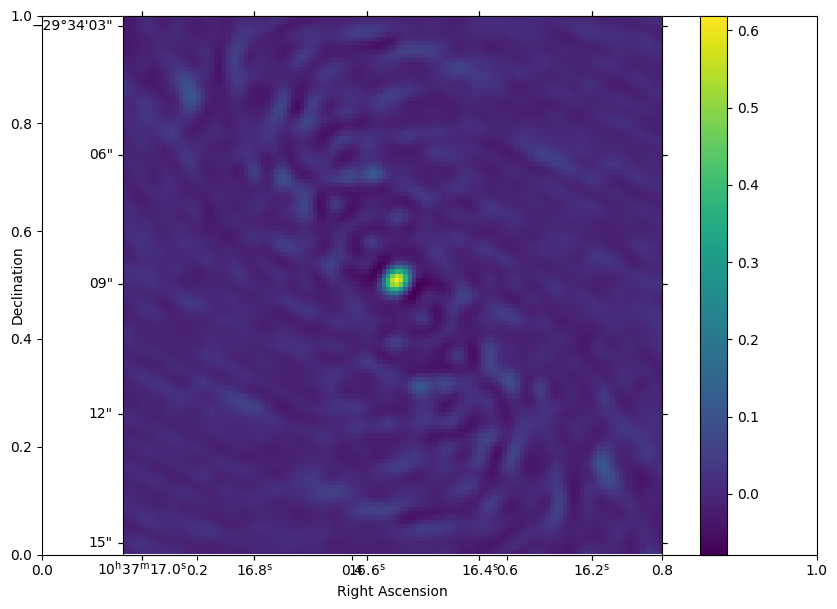

In [9]:
from casatools import image as IA
from astropy.wcs import WCS
import matplotlib.pyplot as plt
import numpy as np

ia = IA()
ia.open('phase_cal.image')
pix = ia.getchunk()[:,:,0,0]
csys = ia.coordsys()
ia.close()

rad_to_deg =  180/np.pi
w = WCS(naxis=2)
w.wcs.crpix = csys.referencepixel()['numeric'][0:2]
w.wcs.cdelt = csys.increment()['numeric'][0:2]*rad_to_deg
w.wcs.crval = csys.referencevalue()['numeric'][0:2]*rad_to_deg
w.wcs.ctype = ['RA---SIN', 'DEC--SIN']

plt.subplots(1,1, figsize=(10,7))
ax = plt.subplot(1, 1, 1, projection=w)
p1 = int(pix.shape[0]*0.25)
p2 = int(pix.shape[0]*0.75)

im = ax.imshow(pix[p1:p2,p1:p2].transpose(), origin='lower',  cmap=plt.cm.viridis)
plt.colorbar(im, ax=ax)
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')

```
# In CASA
tclean(vis='twhya_calibrated.ms',
       imagename='phase_cal',
       field='3',
       spw='',
       specmode='mfs',
       deconvolver='hogbom',
       gridder='standard',
       imsize=[250,250],
       cell=['0.1arcsec'],
       weighting='briggs',
       threshold='0.0mJy',
       interactive=True)
```

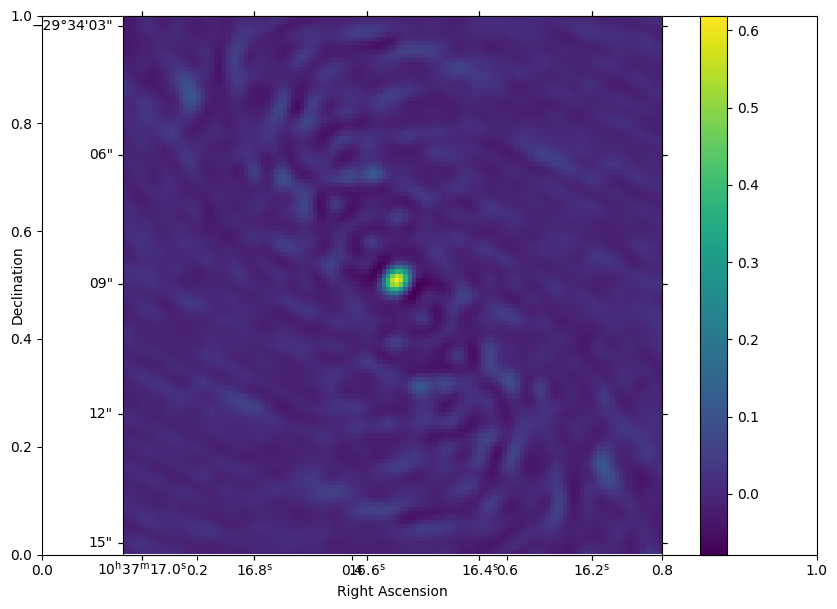

In [11]:
ia = IA()
ia.open('phase_cal.image')
pix = ia.getchunk()[:,:,0,0]
csys = ia.coordsys()
ia.close()

rad_to_deg =  180/np.pi
w = WCS(naxis=2)
w.wcs.crpix = csys.referencepixel()['numeric'][0:2]
w.wcs.cdelt = csys.increment()['numeric'][0:2]*rad_to_deg
w.wcs.crval = csys.referencevalue()['numeric'][0:2]*rad_to_deg
w.wcs.ctype = ['RA---SIN', 'DEC--SIN']

plt.subplots(1,1, figsize=(10,7))
ax = plt.subplot(1, 1, 1, projection=w)
p1 = int(pix.shape[0]*0.25)
p2 = int(pix.shape[0]*0.75)

im = ax.imshow(pix[p1:p2,p1:p2].transpose(), origin='lower',  cmap=plt.cm.viridis)
plt.colorbar(im, ax=ax)
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')

CASA is sure to tell you that you haven't done any cleaning with the
following warning:

    WARN task_tclean    Restoring with an empty model image. Only residuals will be processed to form the output restored image.

Run the command again, this time with niter set to some (arbitrarily
large) number:

![Imaging-tutorial-phase-cal-clean_6.5.4](https://github.com/casangi/casadocs/blob/cas-14472/docs/notebooks/media/Imaging-tutorial-phase-cal-clean_6.5.4.jpg?raw=1){.image-inline width="635" height="347"}

In [12]:
# In CASA
os.system('rm -rf phase_cal.*')

tclean(vis='twhya_calibrated.ms',
       imagename='phase_cal',
       field='3',
       spw='',
       specmode='mfs',
       deconvolver='hogbom',
       gridder='standard',
       imsize=[250,250],
       cell=['0.1arcsec'],
       weighting='briggs',
       threshold='0mJy',
       niter=5000,
       interactive=True)



{'cleanstate': 'running',
 'cyclefactor': 1.0,
 'cycleiterdone': 0,
 'cycleniter': 100,
 'cyclethreshold': 0.11061683297157288,
 'interactiveiterdone': 0,
 'interactivemode': True,
 'interactiveniter': 0,
 'interactivethreshold': 0.0,
 'iterdone': 0,
 'loopgain': 0.10000000149011612,
 'maxpsffraction': 0.800000011920929,
 'maxpsfsidelobe': 0.1785900741815567,
 'minpsffraction': 0.05000000074505806,
 'niter': 5000,
 'nmajordone': 1,
 'nsigma': 0.0,
 'stopcode': 7,
 'summarymajor': array([0]),
 'summaryminor': {0: {}},
 'threshold': 0.0,
 'stopDescription': 'zero mask'}

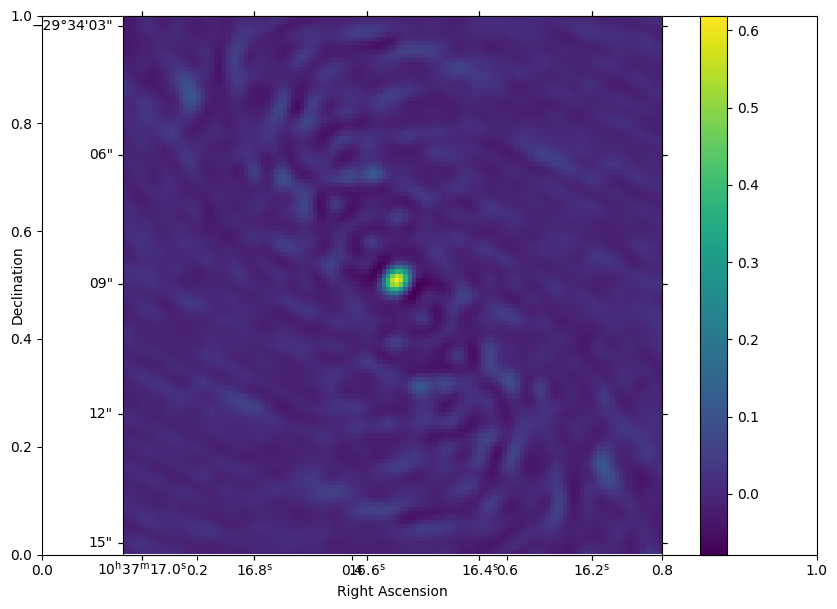

In [13]:
ia = IA()
ia.open('phase_cal.image')
pix = ia.getchunk()[:,:,0,0]
csys = ia.coordsys()
ia.close()

rad_to_deg =  180/np.pi
w = WCS(naxis=2)
w.wcs.crpix = csys.referencepixel()['numeric'][0:2]
w.wcs.cdelt = csys.increment()['numeric'][0:2]*rad_to_deg
w.wcs.crval = csys.referencevalue()['numeric'][0:2]*rad_to_deg
w.wcs.ctype = ['RA---SIN', 'DEC--SIN']

plt.subplots(1,1, figsize=(10,7))
ax = plt.subplot(1, 1, 1, projection=w)
p1 = int(pix.shape[0]*0.25)
p2 = int(pix.shape[0]*0.75)

im = ax.imshow(pix[p1:p2,p1:p2].transpose(), origin='lower',  cmap=plt.cm.viridis)
plt.colorbar(im, ax=ax)
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')

After running this **tclean** task, you will be presented with the GUI
as shown in Figure 3.

In the TCLEAN viewer, make sure that your buttons are set to add a new
oval mask region. You may need to click on the icon showing the "R" in
an oval. Remember that the phase calibrator has been selected because it
is a point source, so you should see a point source in the middle of the
field. Draw an oval mask around the emission region (just the central
dot). If you don't like the region you've selected, hover the mouse over
it and hit "Esc". If you do like it, double click inside the oval and
watch it turn white to create the mask (See Figure 3). When setting the
clean mask, you should aim to capture the real emission and not much
else. If you don't like the mask you have created, toggle the "Add"
option to "Erase", draw a region around the mask, and then double click
to remove the mask. In the "Next Action" section of the GUI, you will
notice several control buttons. Hit the green circle button to begin the
cleaning process. This will run a major cycle of cleaning and then
return. After the first major cycle of cleaning, the plot displays the
residual emission. Compare the brightness of the residuals with that of
the source and with that of the noise. When you are satisfied (or when
tclean has met the residual threshold, 0 mJy by default - meaning that
it stops at the first negative), click the red "X" and tclean will
terminate. In this example, two rounds of cleaning work well. For more
complex targets you may need many rounds of cleaning, and it is possible
to update and add new tclean regions after each major cycle, based on
the look of the residuals. You're aiming for the residuals inside the
mask (i.e. the residuals left over for the source, after subtracting the
scaled model) to look about the same as the noise outside the mask.

Have a quick look at the files that tclean has created.

```
# In CASA
ls
```

All the resulting files have the "phase_cal" prefix, with different
extensions:

- .image is the final cleaned image
- .mask shows the clean mask, or the area that tclean cleaned
- .model is the set of modeled clean components used by tclean (in
  Jy/pixel)
- .pb shows the primary beam response
- .residual shows what was left after you stopped tclean (the "dirty"
  part of the final image)
- .psf shows the synthesized beam
- .sumwt is a single pixel image containing sum of weights per plane

So much good stuff. You can look at all of these using CARTA. If you are
using NRAO machines, you can navigate to your working directory in a
terminal, and then type:

```
%%bash
# In bash
carta --no_browser
```

Copy the URL it returns and paste into a browser window to view your
CARTA session.

## Experiment with TCLEAN

**tclean** includes a lot of options. Remember, you can see the list of
inputs for the task by typing "inp tclean". Now is a good time to get a
feel for what these options can do. One option that is very commonly
tweaked by the user is the weighting scheme used to grid the UV data
into a fourier-plane image. This weighting was "robust=0.5" in the first
example (by default). Try a few different values of the robust parameter
between -2 (uniform) and 2 (natural). Pay attention to how the beam size
changes, as well as the noise in the final image. You can check the
noise level using CARTA -- draw a box on the image and click the
'Statistics' widget (looks like a calculator) at the top of the window.
Remove old versions of the image in case you have run this before:

```
# In CASA
os.system('rm -rf phase_cal_robust.*')
```

Call tclean with briggs weighting and robust = -1. Make a clean mask and
run a few cycles of tclean, until you are happy with the level of the
residuals:

![Imaging-tutorial-phase-cal-robust_6.5.4](https://github.com/casangi/casadocs/blob/master/docs/notebooks/media/Imaging-tutorial-phase-cal-robust_6.5.4.jpg?raw=1){.image-inline width="600"}

In [17]:
# In CASA
tclean(vis='twhya_calibrated.ms',
       imagename='phase_cal_robust',
       field='3',
       spw='',
       specmode='mfs',
       gridder='standard',
       deconvolver='hogbom',
       imsize=[250,250],
       cell=['0.1arcsec'],
       weighting='briggs',
       robust=-1.0,
       threshold='0mJy',
       niter=5000,
       interactive=True)



{'cleanstate': 'running',
 'cyclefactor': 1.0,
 'cycleiterdone': 0,
 'cycleniter': 100,
 'cyclethreshold': 0.1120268926024437,
 'interactiveiterdone': 0,
 'interactivemode': True,
 'interactiveniter': 0,
 'interactivethreshold': 0.0,
 'iterdone': 0,
 'loopgain': 0.10000000149011612,
 'maxpsffraction': 0.800000011920929,
 'maxpsfsidelobe': 0.18052664399147034,
 'minpsffraction': 0.05000000074505806,
 'niter': 5000,
 'nmajordone': 1,
 'nsigma': 0.0,
 'stopcode': 7,
 'summarymajor': array([0]),
 'summaryminor': {0: {}},
 'threshold': 0.0,
 'stopDescription': 'zero mask'}

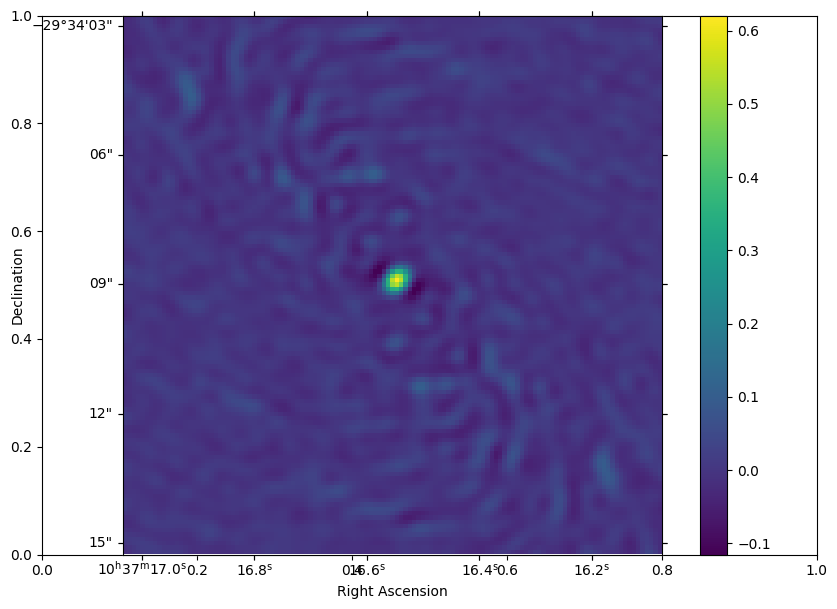

In [18]:
ia = IA()
ia.open('phase_cal_robust.image')
pix = ia.getchunk()[:,:,0,0]
csys = ia.coordsys()
ia.close()

rad_to_deg =  180/np.pi
w = WCS(naxis=2)
w.wcs.crpix = csys.referencepixel()['numeric'][0:2]
w.wcs.cdelt = csys.increment()['numeric'][0:2]*rad_to_deg
w.wcs.crval = csys.referencevalue()['numeric'][0:2]*rad_to_deg
w.wcs.ctype = ['RA---SIN', 'DEC--SIN']

plt.subplots(1,1, figsize=(10,7))
ax = plt.subplot(1, 1, 1, projection=w)
p1 = int(pix.shape[0]*0.25)
p2 = int(pix.shape[0]*0.75)

im = ax.imshow(pix[p1:p2,p1:p2].transpose(), origin='lower',  cmap=plt.cm.viridis)
plt.colorbar(im, ax=ax)
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')

Now is a good time to experiment a bit with tclean - try imaging the
other calibrators (fields 0 and 2; check the 'ScanIntent' again in the
**listobs** output) and making the image size and cell size larger and
smaller.

For example, let's look at the marginally-resolved primary (flux)
calibrator, Ceres (field 2; 'ScanIntent' = 'CALIBRATE_AMPLI#ON_SOURCE'):

In [19]:
# In CASA
os.system('rm -rf amp_cal_robust.*')

tclean(vis='twhya_calibrated.ms',
       imagename='amp_cal_robust',
       field='2',
       spw='',
       specmode='mfs',
       gridder='standard',
       deconvolver='hogbom',
       imsize=[250,250],
       cell=['0.1arcsec'],
       weighting='briggs',
       threshold='0mJy',
       niter=5000,
       interactive=True)



{'cleanstate': 'running',
 'cyclefactor': 1.0,
 'cycleiterdone': 0,
 'cycleniter': 100,
 'cyclethreshold': 1.5978202819824219,
 'interactiveiterdone': 0,
 'interactivemode': True,
 'interactiveniter': 0,
 'interactivethreshold': 0.0,
 'iterdone': 0,
 'loopgain': 0.10000000149011612,
 'maxpsffraction': 0.800000011920929,
 'maxpsfsidelobe': 0.40369388461112976,
 'minpsffraction': 0.05000000074505806,
 'niter': 5000,
 'nmajordone': 1,
 'nsigma': 0.0,
 'stopcode': 7,
 'summarymajor': array([0]),
 'summaryminor': {0: {}},
 'threshold': 0.0,
 'stopDescription': 'zero mask'}

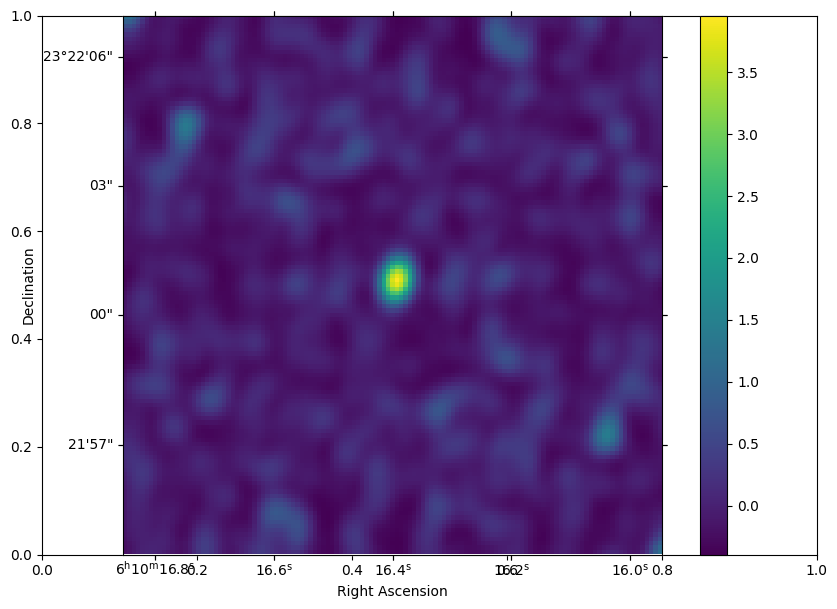

In [20]:
ia = IA()
ia.open('amp_cal_robust.image')
pix = ia.getchunk()[:,:,0,0]
csys = ia.coordsys()
ia.close()

rad_to_deg =  180/np.pi
w = WCS(naxis=2)
w.wcs.crpix = csys.referencepixel()['numeric'][0:2]
w.wcs.cdelt = csys.increment()['numeric'][0:2]*rad_to_deg
w.wcs.crval = csys.referencevalue()['numeric'][0:2]*rad_to_deg
w.wcs.ctype = ['RA---SIN', 'DEC--SIN']

plt.subplots(1,1, figsize=(10,7))
ax = plt.subplot(1, 1, 1, projection=w)
p1 = int(pix.shape[0]*0.25)
p2 = int(pix.shape[0]*0.75)

im = ax.imshow(pix[p1:p2,p1:p2].transpose(), origin='lower',  cmap=plt.cm.viridis)
plt.colorbar(im, ax=ax)
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')

Look at the image in CARTA. Notice that Ceres is somewhat resolved, as
we saw from the **plotms** plots above.

If you try a really big pixel size you will see things break. It is
recommended to have the pixel size small compared to the synthesized
beam for tclean purposes (tclean quantizes the deconvolution in units of
pixels). When the pixel size is big compared to the synthesized beam the
imaging in general will degrade, even independent of how you tclean.

![Imaging-tutorial-amp-cal-big-pix_6.5.4](https://github.com/casangi/casadocs/blob/master/docs/notebooks/media/Imaging-tutorial-amp-cal-big-pix_6.5.4.jpg?raw=1){.image-inline width="600"}

In [21]:
# In CASA
os.system('rm -rf amp_cal_bigpix.*')

tclean(vis='twhya_calibrated.ms',
       imagename='amp_cal_bigpix',
       field='2',
       spw='',
       specmode='mfs',
       gridder='standard',
       deconvolver='hogbom',
       imsize=[50,50],
       cell=['0.5arcsec'],
       weighting='briggs',
       threshold='0mJy',
       niter=5000,
       interactive=True)



{'cleanstate': 'running',
 'cyclefactor': 1.0,
 'cycleiterdone': 0,
 'cycleniter': 100,
 'cyclethreshold': 1.7204196453094482,
 'interactiveiterdone': 0,
 'interactivemode': True,
 'interactiveniter': 0,
 'interactivethreshold': 0.0,
 'iterdone': 0,
 'loopgain': 0.10000000149011612,
 'maxpsffraction': 0.800000011920929,
 'maxpsfsidelobe': 0.3287648558616638,
 'minpsffraction': 0.05000000074505806,
 'niter': 5000,
 'nmajordone': 1,
 'nsigma': 0.0,
 'stopcode': 7,
 'summarymajor': array([0]),
 'summaryminor': {0: {}},
 'threshold': 0.0,
 'stopDescription': 'zero mask'}

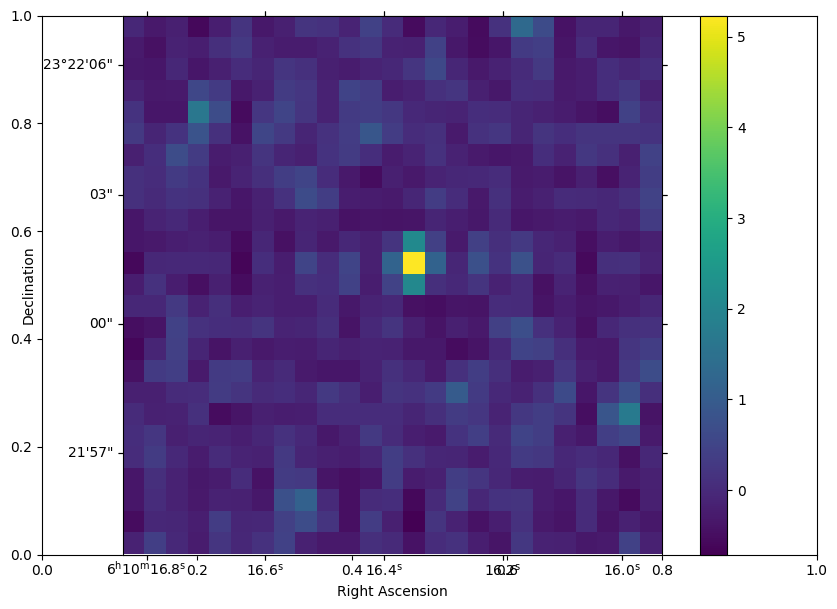

In [22]:
ia = IA()
ia.open('amp_cal_bigpix.image')
pix = ia.getchunk()[:,:,0,0]
csys = ia.coordsys()
ia.close()

rad_to_deg =  180/np.pi
w = WCS(naxis=2)
w.wcs.crpix = csys.referencepixel()['numeric'][0:2]
w.wcs.cdelt = csys.increment()['numeric'][0:2]*rad_to_deg
w.wcs.crval = csys.referencevalue()['numeric'][0:2]*rad_to_deg
w.wcs.ctype = ['RA---SIN', 'DEC--SIN']

plt.subplots(1,1, figsize=(10,7))
ax = plt.subplot(1, 1, 1, projection=w)
p1 = int(pix.shape[0]*0.25)
p2 = int(pix.shape[0]*0.75)

im = ax.imshow(pix[p1:p2,p1:p2].transpose(), origin='lower',  cmap=plt.cm.viridis)
plt.colorbar(im, ax=ax)
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')

---------NO FURTHER UOPDATES TO THIS CASA GUIDE---------


To see the issues clearly here, compare the beam in this image to the
one in the first image we made (with 5x smaller pixels).

## ASIDE: See the effects of calibration and flagging

This section gives an aside intended to demonstrate the effect of
calibration. If you are focused on learning only imaging, feel free to
skip this section.

The data that we are imaging went through a careful and detailed
calibration process. What effect did this actually have? Let's image the
phase calibrator with and without calibration and with and without
flagging just to get an idea of how our processing changed the final
image.

First you need to copy the uncalibrated data from the working directory.
This step will differ depending on where you are storing the data. The
net result we want is to have a copy of the uncalibrated data in the
current working directory.

If you downloaded the full data package, copy the uncalibrated data to
your current working directory.

```
# In CASA
os.system('tar -xvf ../working/twhya_uncalibrated.ms.tar')
```

If you downloaded only the calibrated data set, you can use "wget" again
to download the uncalibrated data at this time:

```
%%bash
# In bash
 % wget -r -np -nH --cut-dirs=4 --reject "index.html*" https://bulk.cv.nrao.edu/almadata/public/ALMA_firstlooks/twhya_uncalibrated.ms.tar
```

Or you can download the file via your browser at the following links:
<https://bulk.cv.nrao.edu/almadata/public/ALMA_firstlooks/twhya_uncalibrated.ms.tar>

Now let's TCLEAN the uncalibrated data, again focusing on the phase
calibrator (field 3) and using the same calls as before.

![Imaging-tutorial-phase-cal-uncalibrated_6.5.4](https://github.com/casangi/casadocs/blob/master/docs/notebooks/media/Imaging-tutorial-phase-cal-uncalibrated_6.5.4.jpg?raw=1){.image-inline width="600"}

```
# In CASA
os.system('rm -rf phase_cal_uncalibrated.*')
tclean(vis='twhya_uncalibrated.ms',
       imagename='phase_cal_uncalibrated',
       field='3',
       spw='',
       specmode='mfs',
       gridder='standard',
       deconvolver='hogbom',
       imsize=[250,250],
       cell=['0.1arcsec'],
       weighting='briggs',
       threshold='0mJy',
       niter=5000,
       interactive=True)
```

If you can find a source to tclean then more power to you, but this is a
mess. It's a good thing that we calibrated... In the raw (but still Tsys
and WVR corrected) data you can see echos of the calibrator throughout
the field, but the calibration is required to make the image coherent.
Inspect the imaged uncalibrated data using CARTA.

Now let's see the effect that flagging had on the data. Copy the
unflagged (but otherwise calibrated) data from the working directory to
our local directory:

```
# In CASA
os.system('tar -xvf ../working/twhya_calibrated_unflagged.ms.tar')
```

or again, using wget:

```
%%bash
# In bash
 % wget -r -np -nH --cut-dirs=4 --reject "index.html*" https://bulk.cv.nrao.edu/almadata/public/ALMA_firstlooks/twhya_calibrated_unflagged.ms.tar
```

Or you can download the file via your browser at the [following link](https://bulk.cv.nrao.edu/almadata/public/ALMA_firstlooks/twhya_calibrated_unflagged.ms.tar).

Now image the calibrated but unflagged data for the secondary calibrator
using the same parameters as before.

![Imaging-tutorial-phase-cal-unflagged_6.5.4](https://github.com/casangi/casadocs/blob/master/docs/notebooks/media/Imaging-tutorial-phase-cal-unflagged_6.5.4.jpg?raw=1){.image-inline width="600"}

```
# In CASA
os.system('rm -rf phase_cal_unflagged.*')

tclean(vis='twhya_calibrated_unflagged.ms',
       imagename='phase_cal_unflagged',
       field='3',
       spw='',
       specmode='mfs',
       gridder='standard',
       deconvolver='hogbom',
       imsize=[250,250],
       cell=['0.1arcsec'],
       weighting='briggs',
       threshold='0mJy',
       niter=5000,
       interactive=True)
```

In contrast to the uncalibrated data, the unflagged data are coherent,
but they have clear artifacts in the residuals. Flagging has definitely
improved the quality of the data, but in overall good quality data like
we have here, we can see the target source.

## Image the science target

Of course, the whole point of calibration is to calibrate the *science*
data. Here, the TW Hydra observations use field 5, which we know from
the output of **listobs**, above. As the final step in the basic imaging
tutorial, let's now image the continuum in TW Hydra. First, we will
"split out" the science data into its own data set using the CASA task
**split**. While not strictly necessary, this is a common step that
makes managing the data easier. At the same time we will smooth (i.e.
average) the data in frequency using width=8 to do the averaging. This
reduces the data volume without losing much information, since we are
really only interested in continuum imaging at this point. Although this
data set was already designed to be manageable, this smoothing trick is
good to keep in mind because ALMA can produce very large data sets.

```
# In CASA
os.system('rm -rf twhya_smoothed.ms')

split(vis='twhya_calibrated.ms', field='5', width='8', outputvis='twhya_smoothed.ms', datacolumn='data')

listobs('twhya_smoothed.ms')
```

Now make a continuum image of the split-out data. Notice that TW Hydra
has now been re-labeled as field 0 in the new data set because we split
out only that field. We'll use the same tclean settings as for the phase
calibrator, since we have covered the full primary beam with our image
size and cell size combination. Again, specify interactive mode and
leave the threshold unset for the time being.

![Imaging-tutorial-twhydra-cont_6.5.4](https://github.com/casangi/casadocs/blob/master/docs/notebooks/media/Imaging-tutorial-twhydra-cont_6.5.4.jpg?raw=1){.image-inline width="600"}

```
# In CASA
os.system('rm -rf twhya_cont.*')

tclean(vis='twhya_smoothed.ms',
       imagename='twhya_cont',
       field='0',
       spw='',
       specmode='mfs',
       gridder='standard',
       deconvolver='hogbom',
       imsize=[250,250],
       cell=['0.1arcsec'],
       weighting='briggs',
       robust=0.5,
       threshold='0mJy',
       niter=5000,
       interactive=True)
```

Draw a clean mask around the visible emission using the mask tools and
then run tclean until the emission from the TW Hydra disk is less than
or comparable to the residuals around it. In this interactive mode of
cleaning, you decide when tclean should stop, and at that point you hit
the red X. If instead you did want to clean automatically down to a
threshold, you can specify a threshold that is a small multiple of the
rms noise either in the call to tclean above or by typing it in to the
tclean GUI if you started the session interactively.

Have a look at the image - TW Hydra is very bright and you can see that
it is extended relative to the size of the beam, which is represented by
an oval, with major and minor axes marked, in the very bottom left
corner of the CARTA image window. The residuals aren't perfect, but we
will improve them in subsequent lessons.

But wait! you might be asking. Didn't you say that there are spectral
lines in this spectral window? Yes, the spectral window that we have
imaged here as continuum also contains a N2H+ emission line. In this
case, the N2H+ emission is faint enough that neglecting to flag the line
channels before imaging makes no difference to the final continuum
image. For this and the other continuum first look tutorials, we have
thus ignored the line to focus on the basic steps of imaging and
self-calibration. In general, however, you should flag channels
containing emission lines in your own data prior to imaging the
continuum. To see how to flag line emission prior to imaging the
continuum in a spectral window, please see this [more advanced tutorial](https://casaguides.nrao.edu/index.php/IRAS16293_Band9_-_Imaging_for_CASA_6.6.1).

## Non-interactive clean

So far we have mostly followed an interactive process with tclean.
tclean can also be set up to run without interactive guidance. The three
main parameters to specify are the threshold at which to stop (when the
maximum residual in the tclean region is lower than this threshold,
tclean stops), the mask (the region in which tclean is willing to
identify signal), and the maximum number of iterations. The max
iterations is not strictly required and it is generally recommended that
it be used as more of a failsafe. That is, set it to a number so high
that if tclean gets there something has gone wrong.

First let's take a stab at determining a clean mask. Look at the image
you just made. All of the obvious emission is contained in a box that is
bounded by pixel numbers in a range of something like (100,100) to
(150,150). We'll set that box to be a mask using the "mask" parameter in
the call to tclean. You could also set it by supplying a file (for
example the one created from your earlier interactive version of
tclean).

Now let's determine a stopping threshold for tclean. Again, look at the
previous image using CARTA and draw a box well away from the source to
estimate the noise. Like before, look at the 'Statistics' tab in the
'Regions' box of the interface to find the RMS noise. We see something
like ~7 mJy/beam. Set the threshold to be about twice this, ~15
mJy/beam. A clean threshold several times the rms noise is usually
recommended to avoid adding false sources to the deconvolved image. That
is, you do not want tclean to treat a random noise spike as a source and
deconvolve it from the image. This can be particularly problematic if
you are doing self-calibration (a later lesson). Finally set
niter=10000, which is a lot of iterations. We expect tclean to terminate
before reaching this. For our purposes this is just a big number that's
designed to keep tclean from running forever.

```
# In CASA
os.system('rm -rf twhya_cont_auto.*')

tclean(vis='twhya_smoothed.ms',
       imagename='twhya_cont_auto',
       field='0',
       spw='',
       specmode='mfs',
       gridder='standard',
       deconvolver='hogbom',
       imsize=[250,250],
       cell=['0.1arcsec'],
       mask='box [ [100pix , 100pix] , [150pix, 150pix] ]',
       weighting='briggs',
       robust=0.5,
       threshold='15mJy',
       niter=10000,
       interactive=False)
```

Look ma, no hands!

This noninteractive mode can save you a lot of time and has the
advantage of being very reproducible. Note that you also have a "hybrid"
mode available by starting the tclean process with interactive=True, but
then click the blue arrow button in the top right corner. This tells
tclean to proceed until it hits the maximum number of iterations or the
threshold. This combination mode is nice because you can manually draw
the mask used to tclean. Note that you can also manually set both the
threshold and the maximum number of iterations (which is the product of
the number of major cycles and the iterations per cycle) in the viewer
GUI. Note, however, that best practice for an image with uncertain
calibration and especially one with a bright source, is to clean
interactively at least the first time. In the case where an image may be
"dynamic range limited" (i.e., the quality is set by the accuracy of
calibration and deconvolution) it can be hard to predict the correct
threshold.

As the cleaning cycles proceed, the residuals in the image should
decrease. You can check this in the tclean output in the logger; if the
residuals start to increase you may need to change your stopping
threshold.

## Primary beam correction

An important subtlety of **tclean** is that by default the image
produced by tclean is not corrected for the primary beam (the field of
view) of the individual dishes in the array. The primary beam response
is typically a Gaussian with value 1 at the center of the field. To form
an astronomically correct image of the sky, the output of tclean needs
to be divided by this primary beam (or, in the case of mosaics, the
combination of primary beam patterns used to make the mosaic). For
tclean, there are two ways to do this.

First, you can set the parameter pbcor = True when running tclean. This
will produce an additional image with the extension .image.pbcor, which
is the cleaned image corrected for the primary beam.

Second, CASA stores the primary beam information needed to make this
correction in the file with the .pb extension. The CASA task impbcor can
be used to combine the .pb image with the output image from TCLEAN to
produce a primary-beam corrected image.

First remove the old primary beam corrected image if it exists

```
# In CASA
os.system('rm -rf twhya_cont.pbcor.image')
```

Now correct the image with **impbcor**, and then inspect the output
image in CARTA:

![Imaging-tutorial-pb-correct_6.5.4](https://github.com/casangi/casadocs/blob/master/docs/notebooks/media/Imaging-tutorial-pb-correct_6.5.4.jpg?raw=1){.image-inline width="600"}

```
# In CASA
impbcor(imagename='twhya_cont.image',
        pbimage='twhya_cont.pb',
        outfile='twhya_cont.pbcor.image')
```

It's often very convenient to work in images before primary beam
correction because the noise is the same across the field (e.g., this is
a clean data set to search for signal) but it's very important to
remember to apply this correction before calculating fluxes or
intensities for science.

The imaging of the continuum for this data continues in ['First Look at Self Calibration'](https://casaguides.nrao.edu/index.php/First_Look_at_Self_Calibration_CASA_6.6.1).